In [1]:
import Higgs
from Higgs.tools.ImplementationUtils import readHEPDataCsv, implementMeasurement
from Higgs.tools.MeasurementValidation import *
import Higgs.signals as HS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## ATLAS STXS `VH->bb` 139fb-1 [2007.02873](https://arxiv.org/abs/2007.02873)

The `HZ` weights come from 2007.08542 and are the ratios between the `qq` and
`gg` (CP-even) distributions in Fig. 5 (left) accumulated for each bin.

In [2]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1805282/Table%201/2/csv"
)

binnames = {
    r"$W(\ell\nu)H\quad 150 < p_{T}^{W,\mathrm{truth}} < 250$ GeV": "HW_pTW_med",
    r"$W(\ell\nu)H\quad p_{T}^{W,\mathrm{truth}} > 250$ GeV": "HW_pTW_high",
    r"$Z(\ell\ell/\nu\nu)H\quad 75 < p_{T}^{Z,\mathrm{truth}} < 150$ GeV": "HZ_pTZ_low",
    r"$Z(\ell\ell/\nu\nu)\quad 75 < p_{T}^{Z,\mathrm{truth}} < 150$ GeV": "HZ_pTZ_low",  # different name used in corrmat
    r"$Z(\ell\ell/\nu\nu)H\quad 150 < p_{T}^{Z,\mathrm{truth}} < 250$ GeV": "HZ_pTZ_med",
    r"$Z(\ell\ell/\nu\nu)\quad 150 < p_{T}^{Z,\mathrm{truth}} < 250$ GeV": "HZ_pTZ_med",  # different name used in corrmat
    r"$Z(\ell\ell/\nu\nu)H\quad p_{T}^{Z,\mathrm{truth}} > 250$ GeV": "HZ_pTZ_high",
    r"$Z(\ell\ell/\nu\nu)\quad p_{T}^{Z,\mathrm{truth}} > 250$ GeV": "HZ_pTZ_high",  # different name used in corrmat
}

for i in (0, 1):
    dfs[i].set_index("STXS region", inplace=True)
    dfs[i].rename(index=binnames, inplace=True)
df = (1e-3 * dfs[0][["SM prediction [fb]", "error +"]]).rename(
    columns={"SM prediction [fb]": "ref", "error +": "refUnc"}
)

df["obs"] = 1e-3 * dfs[1]["Result [fb]"]
df["obsUnc"] = 1e-3 * np.sqrt(
    np.sum(dfs[1][["Stat. +", "Th. sig. +", "Th. bkg. +", "Exp. +"]] ** 2, axis=1)
)
bins = {
    x: {
        "obs": [y.obs - y.obsUnc, y.obs, y.obs + y.obsUnc],
        "ref": [y.ref - y.refUnc, y.ref, y.ref + y.refUnc],
    }
    for x, y in df.iterrows()
}

HWproc = {"channels": [["HW", "bb"]]}
HZproc = {"channels": [["qqHZ", "bb"], ["ggHZ", "bb"]]}
for key, bin in bins.items():
    if key.startswith("HW"):
        bins[key]["process"] = HWproc
    elif key.startswith("HZ"):
        bins[key]["process"] = HZproc
bins["HZ_pTZ_low"]["channelWeights"] = [1.0, 2.2273]
bins["HZ_pTZ_med"]["channelWeights"] = [1.0, 2.435]
bins["HZ_pTZ_high"]["channelWeights"] = [1.0, 3.041]

dfcorr = (
    readHEPDataCsv("https://www.hepdata.net/download/table/ins1805282/Table%202/2/csv")[
        0
    ]
    .set_index(["PTV_X", "PTV_Y"])
    .rename(index=binnames)
)
corrmat = pd.concat(
    [
        part.rename(columns={"Correlation": key}).droplevel(0)
        for key, part in dfcorr.groupby(level=0)
    ],
    axis=1,
)

measFile = implementMeasurement(
    "2007.02873",
    "https://doi.org/10.17182/hepdata.94800.v2",
    bins,
    prefix="bb_VH",
    corrMatExp=corrmat,
    referenceMass=125,
    massResolution=10,
)


Looks good. Saving this to bb_VH_LHC13_ATLAS_139.json


This validation plot can be compared to [Aux. Fig. 25](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/HIGG-2018-51/figaux_25.png). The agreement isn't great but in the right ballpark.

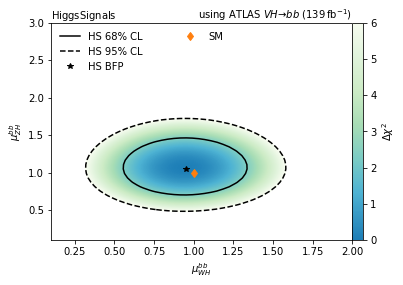

In [3]:
meas = HS.Measurement(measFile)

mu1 = np.linspace(0.1, 2)
mu2 = np.linspace(0.1, 3)


def modFacs(muW, muZ):
    return {x: [muW] if x.startswith("HW") else [muZ, muZ] for x in bins.keys()}

fig, ax = validateMeasurementModFactors(meas, mu1, mu2, modFacs, r"$VH\to bb$")
ax.plot(1, 1, marker="d", c="tab:orange", ls="none", label="SM")
ax.legend(loc="upper center", frameon=False)

ax.set_xlabel(r"$\mu_{WH}^{bb}$")
ax.set_ylabel(r"$\mu_{ZH}^{bb}$")
plt.show()


## ATLAS `vbfH -> bb` 139fb-1 [2011.08280](https://arxiv.org/abs/2011.08280)

Includes the results of [2010.13651](https://arxiv.org/abs/2010.13651). The total cxn values given in the conclusions have the wrong unit (fb instead of pb), while in the results sections the units are correct...

In [4]:
measFile = implementMeasurement(
    "2011.08280",
    "p. 20 (combined result)",
    {
        "vbfH_bb": {
            "obs": [
                2.16 - np.sqrt(0.66 ** 2 + 0.35 ** 2),
                2.16,
                2.16 + np.sqrt(0.67 ** 2 + 0.4 ** 2),
            ],
            "process": {"channels": [["vbfH", "bb"]]},
        }
    },
    prefix="bb_vbfH",
    referenceMass=125,
    massResolution=10,
)


Looks good. Saving this to bb_vbfH_LHC13_ATLAS_126.json


Simple check that this roughly matches the quoted signal strength.

In [5]:
import Higgs.predictions as HP

meas = HS.Measurement(measFile)
assert np.isclose(
    2.16
    / HP.SMHiggsEW(meas.referenceMass()).channelRate(meas.collider(), "vbfH", "bb"),
    0.99,
    atol=0.1,
)


## ATLAS `ttH>bb` 139fb-1 [2111.06712](https://arxiv.org/abs/2111.06712)

They treat `tH` and `tWH` as background. While this does not make a whole lot of sense, we can't do any better than just implementing it like that as well. Since most of the pT dependence would come from those sub-channels anyway, we ignore the STXS bins and only implement the inclusive signal strength.

In [6]:
measFile = implementMeasurement(
    "2111.06712",
    "p. 20 (combined result)",
    {
        "Htt_bb": {
            "obs": [
                0.354480 - np.sqrt(0.196977 ** 2 + 0.275904 ** 2),
                0.354480,
                0.354480 + np.sqrt(0.199089 ** 2 + 0.299332 ** 2),
            ],
            "ref": [1, 1, 1],  # signal strength measurement
            "process": {"channels": [["Htt", "bb"]]},
        }
    },
    prefix="bb_Htt",
    referenceMass=125,
    massResolution=10,
)

meas = HS.Measurement(measFile)
pred = HP.Predictions()
h = pred.addParticle(HP.NeutralScalar("h"))
h.setMass(meas.referenceMass())
HP.effectiveCouplingInput(h, HP.smLikeEffCouplings, reference=meas.referenceModel())
assert np.isclose(meas(pred, {"Htt_bb": [0.35448]}), 0)


Looks good. Saving this to bb_Htt_LHC13_ATLAS_139.json


## CMS `H>bb` combination [1808.08242](http://arxiv.org/abs/1808.08242)

This combination contains some Run-1 data, which is also included in the Run-1 combination. However, the sensitivity here is driven by Run-2 data and no combination of only the 13TeV datasets is available, so this is probably ok for now.

In [7]:
def murange(central, stat, syst):
    comb = np.sqrt(stat ** 2 + syst ** 2)
    return [central - comb, central, central + comb]


subMeasurements = {
    "ggF": {"obs": murange(2.8, 2.08, 1.3), "process": {"channels": [["H", "bb"]]}},
    "vbf": {
        "obs": murange(2.53, 0.98, 1.17),
        "process": {"channels": [["vbfH", "bb"]]},
    },
    "ttH": {
        "obs": murange(0.85, 0.23, 0.37),
        "process": {"channels": [[p, "bb"] for p in ("Htt", "Ht", "HtW")]},
    },
    "WH": {"obs": murange(1.24, 0.29, 0.24), "process": {"channels": [["HW", "bb"]]}},
    "ZH": {"obs": murange(0.88, 0.24, 0.16), "process": {"channels": [["HZ", "bb"]]}},
}
for m in subMeasurements.values():
    m["ref"] = [1, 1, 1]


measFile = implementMeasurement(
    "1808.08242",
    "Fig. 3",
    subMeasurements,
    prefix="bb",
    referenceMass=125.09,
    massResolution=10,
    luminosity=5.1 + 19.8 + 77.2,
)


Looks good. Saving this to bb_LHC13_CMS_102.json


Nothing to compare to, but looks reasonable.

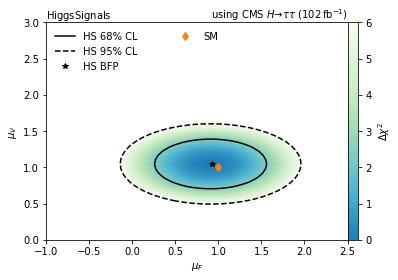

In [8]:
meas = HS.Measurement(measFile)

mu1 = np.linspace(-1, 2.5)
mu2 = np.linspace(0, 3)


def modFacs(muF, muV):
    return {
        x: 3 * [muF] if x == "ggF" or x == "ttH" else [muV]
        for x in subMeasurements.keys()
    }


fig, ax = validateMeasurementModFactors(
    meas,
    mu1,
    mu2,
    modFacs,
    r"$H\to \tau\tau$",
)
ax.plot(1, 1, marker="d", c="tab:orange", ls="none", label="SM")
ax.legend(loc="upper center", frameon=False)

ax.set_xlabel(r"$\mu_F$")
ax.set_ylabel(r"$\mu_V$")
plt.show()
